# Other Models

Try different models to compare their performance with the "Two logistic models" used in the DEMO. 

## S-learner

Instead of using two logistic model let's use only one model with "treatment" as another feature:

$$
\text{Uplift (X) =   } P(Y = 1| T = 1| X) - P(Y = 1 | T = 0 | X) \\
\\
\text{but using the same model for the two terms}
$$

In [21]:
import numpy as np 
import pandas as pd 

DATA_PATH = '../data/raw/criteo-uplift-v2.1.csv'

df = pd.read_csv(DATA_PATH)

df.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,13979592.0,19.620297,5.377464,12.616365,12.616365,21.923413,24.436459,26.745255
f1,13979592.0,10.069977,0.104756,10.059654,10.059654,10.059654,10.059654,16.344187
f2,13979592.0,8.446582,0.299316,8.214383,8.214383,8.214383,8.723335,9.051962
f3,13979592.0,4.178923,1.336645,-8.398387,4.679882,4.679882,4.679882,4.679882
f4,13979592.0,10.338837,0.343308,10.280525,10.280525,10.280525,10.280525,21.123508
f5,13979592.0,4.028513,0.431097,-9.011892,4.115453,4.115453,4.115453,4.115453
f6,13979592.0,-4.155356,4.577914,-31.429784,-6.699321,-2.411115,0.294443,0.294443
f7,13979592.0,5.101765,1.205248,4.833815,4.833815,4.833815,4.833815,11.998401
f8,13979592.0,3.933581,0.056660,3.635107,3.910792,3.971858,3.971858,3.971858
f9,13979592.0,16.027638,7.018975,13.190056,13.190056,13.190056,13.190056,75.295017


In [22]:
feature_cols = [f'f{i}' for i in range(12)]

feature_cols.append("treatment")

target = 'conversion'


Again, a simple Logistic Regression

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df[feature_cols]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=500))])
model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('logreg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not w

In [24]:
X_test_treat = X_test.copy()
X_test_ctrl  = X_test.copy()

X_test_treat["treatment"] = 1
X_test_ctrl["treatment"]  = 0

p_treat = model.predict_proba(X_test_treat)[:, 1]
p_ctrl  = model.predict_proba(X_test_ctrl)[:, 1]

uplift_s = p_treat - p_ctrl




df_test = X_test.copy()

df_test["p_treatment"] = p_treat
df_test["p_control"]   = p_ctrl
df_test["uplift_score"] = uplift_s

df_test["treatment"]  = df.loc[X_test.index, "treatment"]
df_test["conversion"] = df.loc[X_test.index, "conversion"]



In [25]:
df_test_sorted = df_test.sort_values("uplift_score", ascending=False).reset_index(drop=True)


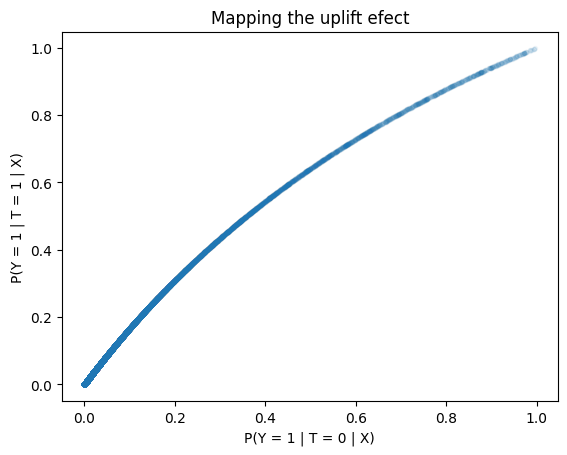

In [26]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_test["p_control"], df_test["p_treatment"],'.', alpha = 0.05)
plt.title('Mapping the uplift efect')
plt.xlabel('P(Y = 1 | T = 0 | X)')
plt.ylabel('P(Y = 1 | T = 1 | X)')
plt.show()

In [27]:
percentiles = np.linspace(0.01, 1.0, 100)
N = len(df_test_sorted)

treat_rates = []
control_rates = []
uplift_local = []

for p in percentiles:
    k = int(p * N)
    subset = df_test_sorted.iloc[:k]

    treat_rate = subset[subset["treatment"] == 1]["conversion"].mean()
    control_rate = subset[subset["treatment"] == 0]["conversion"].mean()

    treat_rates.append(treat_rate)
    control_rates.append(control_rate)
    uplift_local.append(treat_rate - control_rate)

treat_rates = np.array(treat_rates)
control_rates = np.array(control_rates)
uplift_local = np.array(uplift_local)


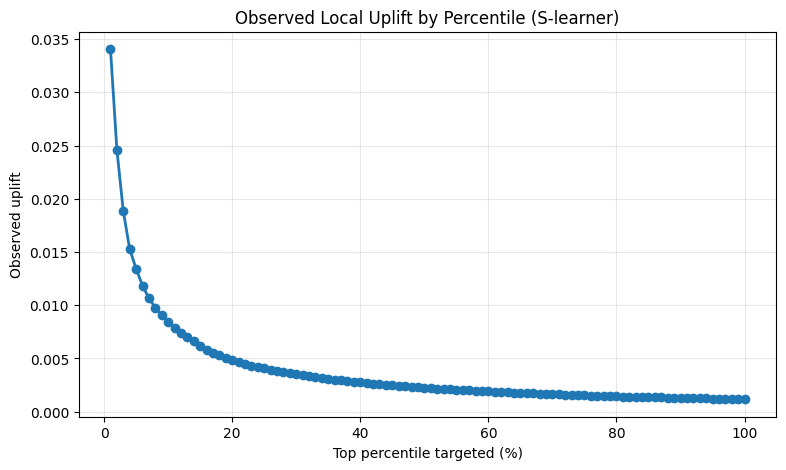

In [28]:
plt.figure(figsize=(9,5))
plt.plot(percentiles * 100, uplift_local, linewidth=2, marker="o")

plt.xlabel("Top percentile targeted (%)")
plt.ylabel("Observed uplift")
plt.title("Observed Local Uplift by Percentile (S-learner)")
plt.grid(alpha=0.3)
# plt.ylim(0, 0.004) 
plt.show()


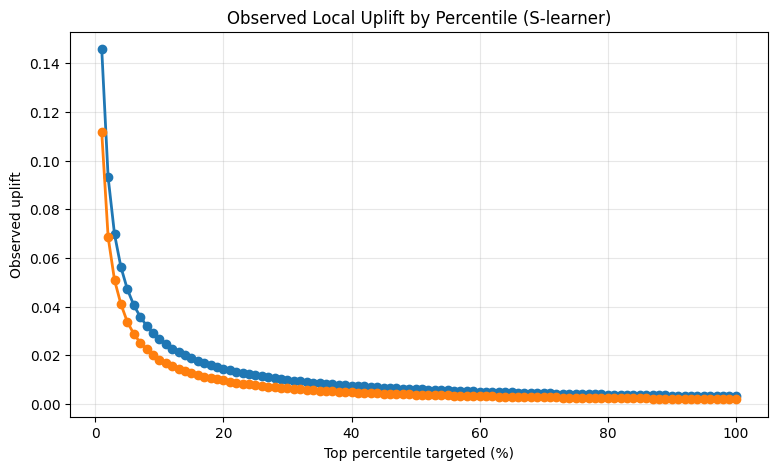

In [29]:
plt.figure(figsize=(9,5))
plt.plot(percentiles * 100, treat_rates, linewidth=2, marker="o")
plt.plot(percentiles * 100, control_rates, linewidth=2, marker="o")

plt.xlabel("Top percentile targeted (%)")
plt.ylabel("Observed uplift")
plt.title("Observed Local Uplift by Percentile (S-learner)")
plt.grid(alpha=0.3)
# plt.ylim(0, 0.004) 
plt.show()

## Class Transformation

This approach uses only one model and it is explicitly created for uplift modeling. The main purpose is to transform a causal problem into a binary classification.
This new variable *Z* shows if the treatment was correct or was not correct. 

$$

Z =
\begin{cases}
1 & \text{si } (T = 1 \land Y = 1)\ \text{o}\ (T = 0 \land Y = 0) \\
0 & \text{si } (T = 1 \land Y = 0)\ \text{o}\ (T = 0 \land Y = 1)
\end{cases}

$$

*Z* means that the user is "good" candidate for treatment (1) or is better not to treat (0)
- T = 1 and Y = 1 : there was treatment and a conversion (this is what we want)
- T = 0 and Y = 0 : there was neither treatment nor conversion (we should treat them, maybe treat helps conversion)
- T = 1 and Y = 0 : there was a treatment but not conversion (we shouldn't try again, waste of resources)
- T = 0 and Y = 1 : there was not a treatment, yet aconversion (why treat? they convert without it!)

In [35]:
from xgboost import XGBClassifier

feature_cols = [f"f{i}" for i in range(12)]
T = "treatment"
Y = "conversion"

df["Z"] = (((df[T] == 1) & (df[Y] == 1)) | ((df[T] == 0) & (df[Y] == 0))).astype(int)


X = df[feature_cols]
y = df["Z"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)



In [36]:
model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

This model predicts the uplift score directly

In [38]:
uplift_ct = model.predict_proba(X_test)[:, 1]

df_tc = df.loc[X_test.index].copy()

df_tc["uplift_score"] = uplift_ct



In [39]:
df_tc_sorted = df_tc.sort_values("uplift_score", ascending=False).reset_index(drop=True)

*Z* (uplift_ct) is the probability that treat that user is a "good idea"

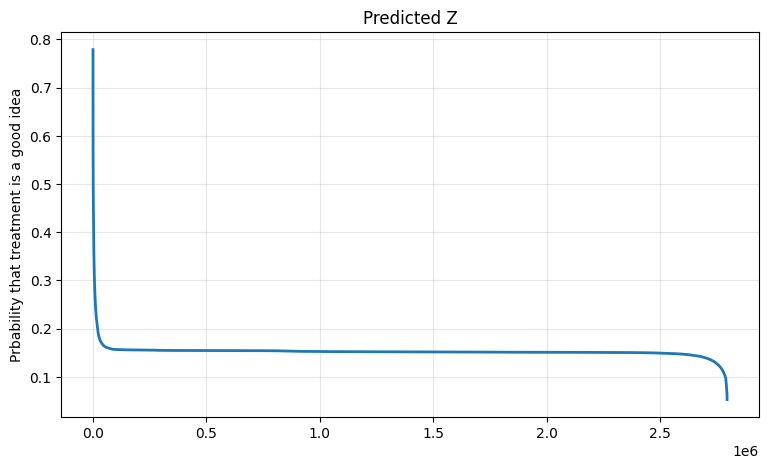

In [49]:
plt.figure(figsize=(9,5))
plt.plot(df_tc_sorted['uplift_score'], linewidth=2)

plt.ylabel("Prbability that treatment is a good idea")
plt.title("Predicted Z")
plt.grid(alpha=0.3)
plt.show()

In [44]:
percentiles = np.linspace(0.01, 1.0, 100)
N = len(df_test_sorted)

treat_rates = []
control_rates = []
uplift_local = []

for p in percentiles:
    k = int(p * N)
    subset = df_tc_sorted.iloc[:k]

    treat_rate = subset[subset["treatment"] == 1]["conversion"].mean()
    control_rate = subset[subset["treatment"] == 0]["conversion"].mean()

    treat_rates.append(treat_rate)
    control_rates.append(control_rate)
    uplift_local.append(treat_rate - control_rate)

treat_rates = np.array(treat_rates)
control_rates = np.array(control_rates)
uplift_local = np.array(uplift_local)

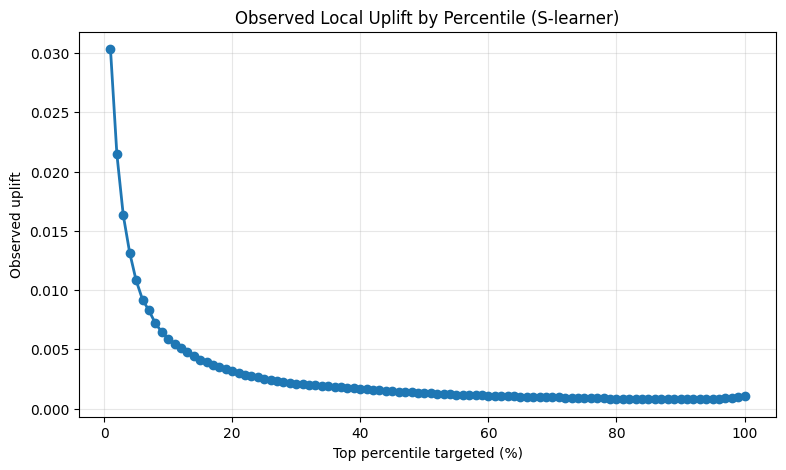

In [45]:
plt.figure(figsize=(9,5))
plt.plot(percentiles * 100, uplift_local, linewidth=2, marker="o")

plt.xlabel("Top percentile targeted (%)")
plt.ylabel("Observed uplift")
plt.title("Observed Local Uplift by Percentile (S-learner)")
plt.grid(alpha=0.3)
# plt.ylim(0, 0.004) 
plt.show()

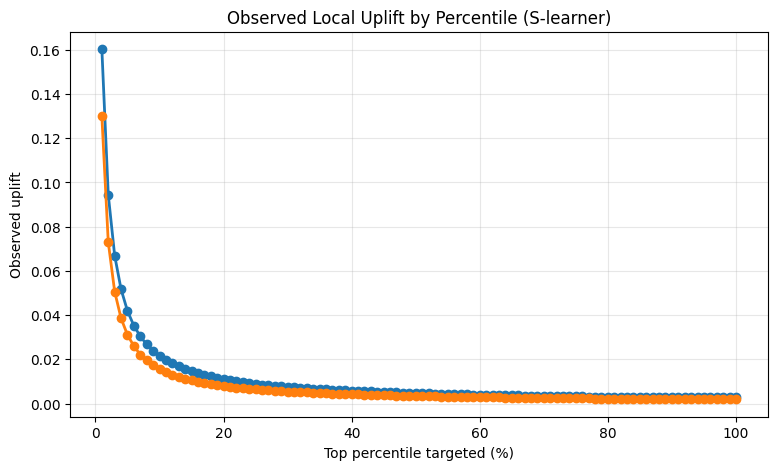

In [46]:
plt.figure(figsize=(9,5))
plt.plot(percentiles * 100, treat_rates, linewidth=2, marker="o")
plt.plot(percentiles * 100, control_rates, linewidth=2, marker="o")

plt.xlabel("Top percentile targeted (%)")
plt.ylabel("Observed uplift")
plt.title("Observed Local Uplift by Percentile (S-learner)")
plt.grid(alpha=0.3)
# plt.ylim(0, 0.004) 
plt.show()